# **Dependancies**

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime

from tqdm import tqdm

from collections import Counter
from scipy.stats import uniform
from scipy.stats import randint
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, PredefinedSplit
from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from collections import Counter
from scipy.stats import uniform
from scipy.stats import randint


In [5]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# **Loading Data**

In [6]:
selected = pd.read_csv("../Data/train_btc_selected_features.csv")
btc = pd.read_csv("../Data/btc_Data.csv")
btc['Date'] = pd.to_datetime(btc['Date'])
btc = btc.set_index("Date")

In [7]:
btcData = btc[selected.columns]
btcData['returns'] = btcData['priceUSD'].pct_change().copy()
Data = btcData.drop(columns=['priceUSD'])
Data = Data[1:]
# divide X and Y
X = Data.iloc[:,0:]
#Y = Data['returns']   # 用returns的话就用这一行，然后把下一行comment掉
Y = btcData['priceUSD'].shift(-30)[1:] # 反之亦然
# Split into three data sets
X_train = X['2016-01-01':'2019-12-31']
X_val = X['2020-01-01':'2021-05-31']
X_test = X['2021-06-01':'2023-01-01']

Y_train = Y['2016-01-01':'2019-12-31']
Y_val = Y['2020-01-01':'2021-05-31']
Y_test = Y['2021-06-01':'2023-01-01']

/tmp/ipykernel_223510/3854812091.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btcData['returns'] = btcData['priceUSD'].pct_change().copy()


In [8]:
X_train.shape

(1461, 32)

In [9]:
estimators=[]
estimators.append(['mixmax',MinMaxScaler()])
estimators.append(['robust',RobustScaler()])
scale=Pipeline(estimators,verbose=True)
scale.fit(X_train)
X_train=scale.transform(X_train)
X_test=scale.transform(X_test)
X_val = scale.transform(X_val)

[Pipeline] ............ (step 1 of 2) Processing mixmax, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing robust, total=   0.0s


In [10]:
X_train = pd.DataFrame(X_train)
X_val = pd.DataFrame(X_val)
X_test = pd.DataFrame(X_test)

In [11]:
X_train.shape

(1461, 32)

In [12]:
# r2_oos
def r2_oos(ret, pred):
    sum_of_sq_res = np.nansum(np.power((ret-pred), 2))
    sum_of_sq_total = np.nansum(np.power(ret, 2))
    
    return 1-sum_of_sq_res/sum_of_sq_total

In [13]:
r2oos_score = make_scorer(r2_oos, greater_is_better=True)  

In [14]:
# GBRT+H
#use pipeline to + a scaler（standardize）, then use gridsearchcv/randomsearchcv
def gbrt(X_train, y_train, X_valid, y_valid, gridsearch = True):
    # pipe = Pipeline([
    #     ('scaler', StandardScaler()),
    #     ('clf', GradientBoostingRegressor(loss='huber', random_state=777))
    # ])
    gbrt_clf = GradientBoostingRegressor(loss='huber', random_state=777)

    # param_grid = dict(learning_rate=[0.05, 0.1, 3],
    #                 n_estimators=[100, 150, 200], 
    #                 max_depth=[3, 10, 20])
    param_grid = dict(learning_rate=uniform(loc=0.01, scale=0.1),
                    n_estimators=randint(50, 150),
                    max_depth=randint(2,12))
    
    # use two scorer:r2oos and mse 
    # scoring_dict = ['r2oos_score', 'neg_mean_squared_error']
    scoring_dict = {'r2_oos':r2oos_score, 'mse':'neg_mean_squared_error'}

    # The indices which have zero or positive values, will be kept in val
    len_X_train = len(X_train)
    len_X_val = len(X_valid)
    val_fold = np.repeat([-1, 0], [len_X_train, len_X_val])
    ps = PredefinedSplit(val_fold)

    X_train_n_val = pd.concat([X_train, X_valid])
    y_train_n_val = pd.concat([y_train, y_valid])
    # notice the cv=ps
    if gridsearch:
        grid = GridSearchCV(gbrt_clf, param_grid, cv=ps, n_jobs=8, verbose=2, scoring= scoring_dict, refit='r2_oos')
    else:
        grid = RandomizedSearchCV(gbrt_clf, param_grid, cv=ps, n_jobs=8, n_iter=15, verbose=2, scoring= scoring_dict, refit ='r2_oos') #could try n_iter=60 for better result

    grid.fit(X_train_n_val, y_train_n_val)

    #get the best score with grid.best_score_
    #get the best parameters with grid.best_params_
    #get the best model with grid.best_estimator_
    return grid

In [15]:
regressor = gbrt(X_train, Y_train, X_val, Y_val, False)

Fitting 1 folds for each of 15 candidates, totalling 15 fits
[CV] END learning_rate=0.09800516623372078, max_depth=2, n_estimators=52; total time=   0.5s
[CV] END learning_rate=0.05182575946976174, max_depth=4, n_estimators=67; total time=   1.3s
[CV] END learning_rate=0.055691104326788594, max_depth=5, n_estimators=55; total time=   1.5s
[CV] END learning_rate=0.07383513820888161, max_depth=3, n_estimators=138; total time=   2.4s
[CV] END learning_rate=0.020229574606073334, max_depth=5, n_estimators=58; total time=   1.4s
[CV] END learning_rate=0.09353558834395793, max_depth=5, n_estimators=93; total time=   2.3s
[CV] END learning_rate=0.06365241932809394, max_depth=3, n_estimators=123; total time=   1.9s
[CV] END learning_rate=0.08579888854045298, max_depth=5, n_estimators=105; total time=   2.5s
[CV] END learning_rate=0.10156038368034381, max_depth=8, n_estimators=120; total time=   6.4s
[CV] END learning_rate=0.08815648588741078, max_depth=9, n_estimators=72; total time=   6.9s
[CV

In [16]:
y_pred=regressor.predict(X_test)

In [17]:
# for check
Y_train_pred=regressor.predict(X_train)
r2_score(Y_train, Y_train_pred) #training score

0.9900174347680654

In [18]:
r2=r2_score(Y_test[:-30],y_pred[:-30]) #score/ r^2
print(f'r2:{r2}')

r2:-0.27618572842796874


In [19]:
def r2_oos2(ret, pred):
    sum_of_sq_res = np.nansum(np.power((ret-pred), 2))
    sum_of_sq_total = np.nansum(np.power(ret, 2))
    
    return 1-sum_of_sq_res/sum_of_sq_total
r2_ooss = r2_oos2(Y_test[:-30].values, pd.Series(y_pred[:-30]))
print(f'r2_oos:{r2_ooss}')

r2_oos:0.8443822225873616


In [20]:
mae=mean_absolute_error(Y_test[:-30],y_pred[:-30]) #mae
print(f'mae:{mae}')

rmse=np.sqrt(mean_squared_error(Y_test[:-30],y_pred[:-30])) #rmse
print(f'rmse:{rmse}')

mape=mean_absolute_percentage_error(Y_test[:-30],y_pred[:-30]) #mape
print(f'mape:{mape}')

mae:11269.617366811975
rmse:15286.118415112167
mape:34.34043322947281


-----------------------------

In [21]:
pre_df = pd.DataFrame(zip(Y_test,y_pred),columns=['Y_test','y_pred'])
pre_df.index = Y_test.index
pre_df

,Y_test,y_pred
Date,,
2021-06-01,33731.0,34937.538920
2021-06-02,33285.0,35920.465507
2021-06-03,34298.0,34949.407906
2021-06-04,35271.0,34865.822884
2021-06-05,34100.0,34865.822884
...,...,...
2022-11-24,NaN,28876.171444
2022-11-25,NaN,28876.171444
2022-11-26,NaN,29001.659848


In [22]:
pre_df['pred_returns'] = pre_df['y_pred'].pct_change()

In [23]:
pre_df

,Y_test,y_pred,pred_returns
Date,,,
2021-06-01,33731.0,34937.538920,NaN
2021-06-02,33285.0,35920.465507,0.028134
2021-06-03,34298.0,34949.407906,-0.027034
2021-06-04,35271.0,34865.822884,-0.002392
2021-06-05,34100.0,34865.822884,0.000000
...,...,...,...
2022-11-24,NaN,28876.171444,0.001537
2022-11-25,NaN,28876.171444,0.000000
2022-11-26,NaN,29001.659848,0.004346


## the original file that produced our result in price_forecasting_results fold was lost(but the code is the same), only the data remains.

<AxesSubplot:>

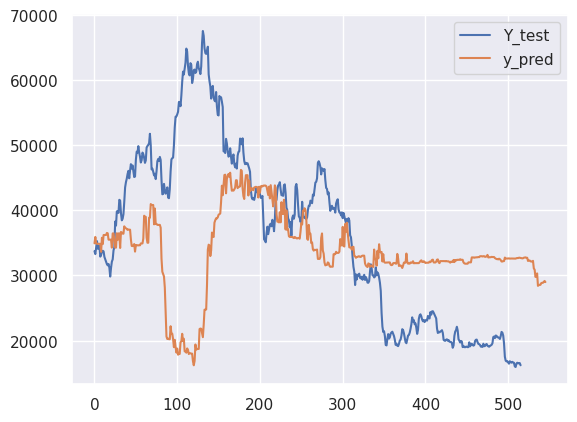

In [24]:
pd.DataFrame(zip(Y_test,y_pred),columns=['Y_test','y_pred']).plot()

In [25]:
pre_df.to_csv("btc_gbrt.csv")

In [26]:

!kdeconnect-cli -n TAS-AN00 --ping-msg 'Script complete!'

Couldn't find device: TAS-AN00
